# In this notebook we will run the 'word2vec' algorithm on our products. Our goal is to embed the products that in our data in $\mathbb{R}^{10}$.

## First we will import the libraries:

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time

## Load the table of similarity and anti similarity between the products:

In [214]:
data = pd.read_csv('word2vec_table.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198694 entries, 0 to 198693
Data columns (total 3 columns):
word       198694 non-null int64
context    198694 non-null int64
label      198694 non-null int64
dtypes: int64(3)
memory usage: 4.5 MB


In [215]:
data.head()

word  context  label
0     1     6184      1
1     1    37710      1
2     1    45337      0
3     1    23457      0
4     2    13176      1

## Now we will shuffle the dataframe:

In [216]:
df = data.sample(frac=1).reset_index(drop=True)
df.head()

word  context  label
0  26406    29447      1
1  33879    40435      0
2  12049    28204      1
3  10678    20869      0
4  43870     5398      0

## Lets define functions that will help us during the training of the network:

In [217]:
def sigmoid(x):
    return (np.exp(x)/(np.exp(x)+1))
def dotProduct(x1,x2):
    return (sum(x1*x2))
def decide(x):
    if x>0.5:
        return (1)
    else:
        return (0)

## We will initialize the embedding with random numbers, and we will train a simple neural network with single layer to learn a good embedding:

In [173]:
embedding = np.random.randn(df['word'].max(),10)

In [174]:
numOfEpoch = 40
epsilon = 0.1

In [175]:
for i in range(numOfEpoch):
    good = 0
    start = time.time()
    for index, row in df.iterrows():
        w = embedding[row['word']-1,:]
        c = embedding[row['context']-1,:]
        z = dotProduct(w,c)
        prob = sigmoid(z);
        pred = decide(prob)
        if pred == row['label']:
            good = good+1
        grad = (row['label']-prob)*prob*c
        embedding[row['word']-1,:] = w + epsilon*grad
    end = time.time()
    print('finish epoch number %d' % (i))
    print('num of good predictions: %d' % (good))
    print('total time for this epoch: %5.5f' % (end-start))

finish epoch number 0
num of good predictions: 99310
total time for this epoch: 39.95012
finish epoch number 1
num of good predictions: 106556
total time for this epoch: 42.19420
finish epoch number 2
num of good predictions: 114808
total time for this epoch: 40.00121
finish epoch number 3
num of good predictions: 123207
total time for this epoch: 43.46327
finish epoch number 4
num of good predictions: 131005
total time for this epoch: 40.48832
finish epoch number 5
num of good predictions: 138118
total time for this epoch: 41.85793
finish epoch number 6
num of good predictions: 144128
total time for this epoch: 47.91686
finish epoch number 7
num of good predictions: 149404
total time for this epoch: 55.24316
finish epoch number 8
num of good predictions: 153751
total time for this epoch: 52.51665
finish epoch number 9
num of good predictions: 157374
total time for this epoch: 58.91737
finish epoch number 10
num of good predictions: 160556
total time for this epoch: 48.80079
finish epo

## Now we have an embedding! First let's save it:

In [177]:
pd.DataFrame(embedding).to_csv('embedding2.csv')

# Now we will examine our result. 
## let's load the products list:

In [260]:
products = pd.read_csv('products.csv')
products = products.drop('aisle_id',axis=1)
products = products.drop('department_id',axis=1)
products.head()

product_id                                       product_name
0           1                         Chocolate Sandwich Cookies
1           2                                   All-Seasons Salt
2           3               Robust Golden Unsweetened Oolong Tea
3           4  Smart Ones Classic Favorites Mini Rigatoni Wit...
4           5                          Green Chile Anytime Sauce

## Our result lay in $\mathbb{R}^{10}$,so we will use dimensionality reduction technique in order to visualize it:  
(We will visualize just the first 500 products because otherwise the plot is too dense)

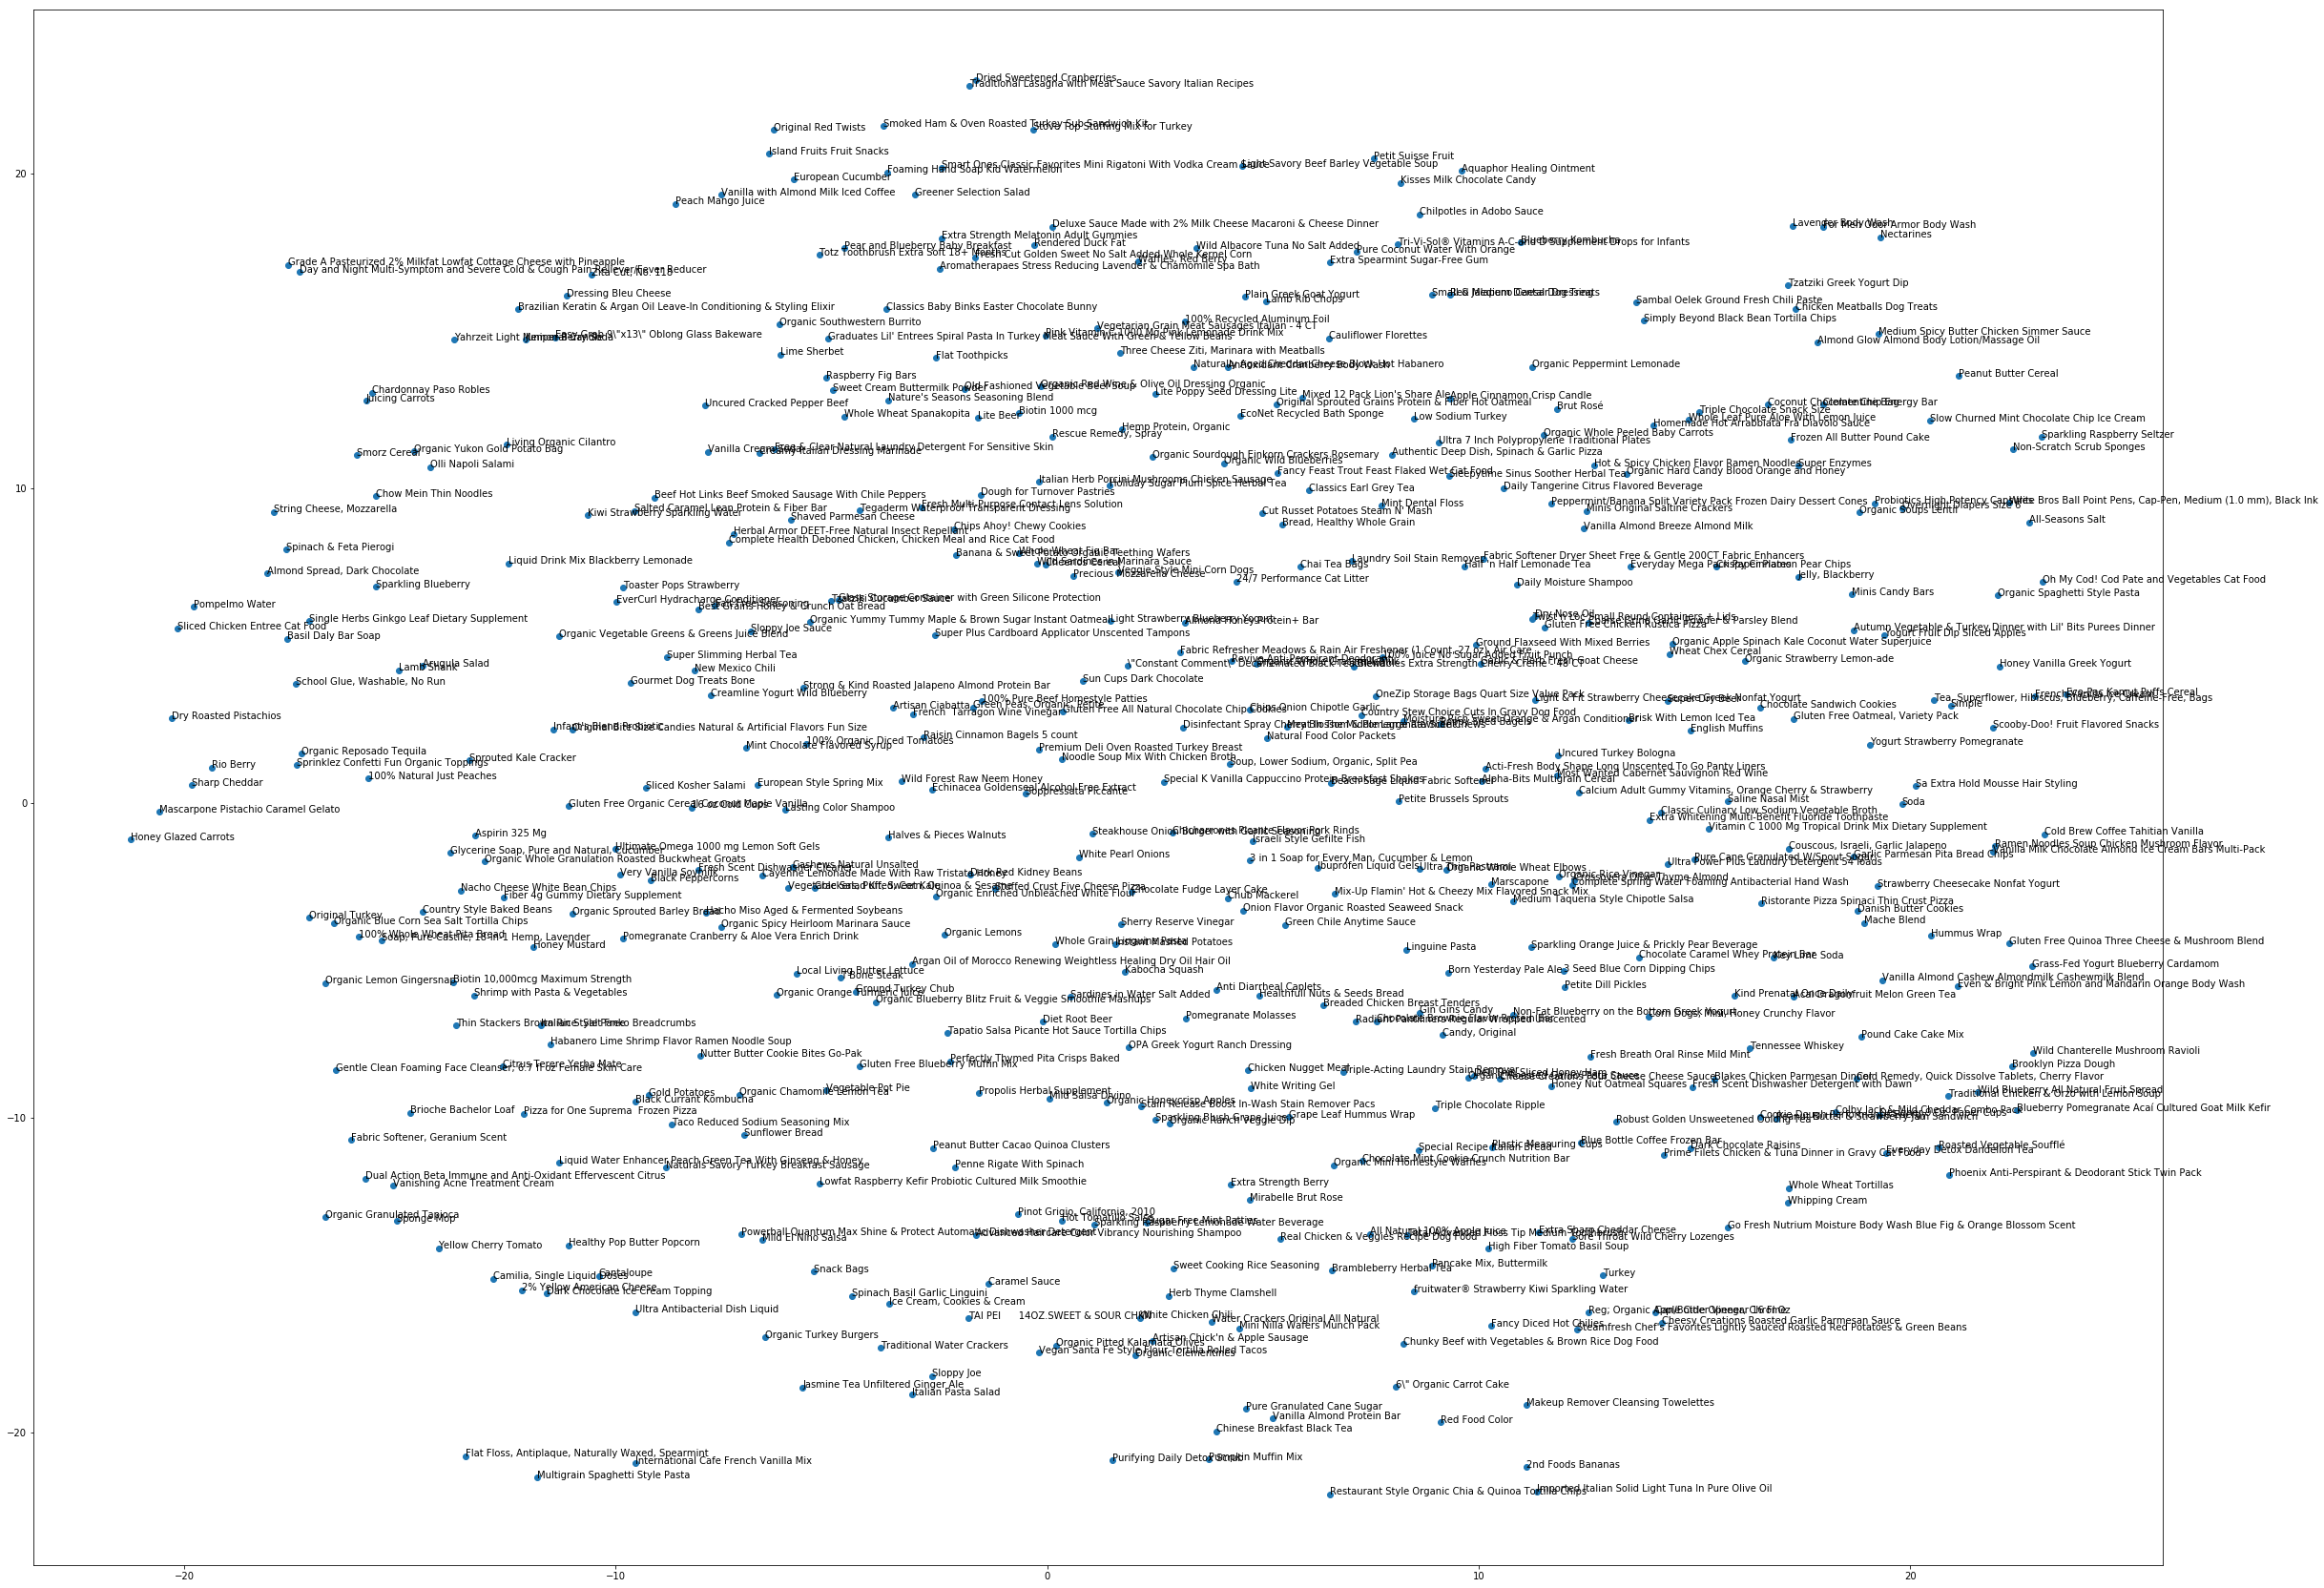

In [251]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=101)
np.set_printoptions(suppress=True)
Y = tsne.fit_transform(embedding[:500,:])

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (40,30)

plt.scatter(Y[:, 0], Y[:, 1])
for label, x, y in zip(products['product_name'].tolist(), Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.show()

## Now let's explore a specific product:

In [253]:
products[products['product_name']=='Bananas']

product_id product_name  aisle_id  department_id
39275       39276      Bananas        24              4

This is it's embedding:

In [255]:
print(embedding[39276])

[-1.38393466 -0.90395889  1.01629678  0.45647064  0.93914111  0.69360589
 -1.52163147 -0.72503473  0.19605388  2.09274503]


### Now let's find the 10 closest products (in term of euclidean distance) to banana:

In [256]:
def distance(x1,x2):
    delta = x1-x2
    dis = dotProduct(delta,delta)
    return (np.sqrt(dis))

In [269]:
minVal = 100
index = -1
disVec = np.zeros(df['word'].max()-1)
count = 0
for i in range(df['word'].max()):
    if i != 39276:
        d = distance(embedding[39276],embedding[i])
        disVec[count] = d
        count = count+1
disSeries = pd.Series(disVec)
small = disSeries.nsmallest(10)
smallDf = products.iloc[small.index.tolist()]
smallDf['distance'] = disSeries
smallDf

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


product_id                                       product_name  distance
20251       20252                    Puff Pastry Dough For Turnovers  1.411554
37990       37991                                 8 Inch Pumpkin Pie  1.495872
23038       23039                              Fat Free Cream Cheese  1.576353
7495         7496                            Decorating Decors Stars  1.593413
26616       26617  with Bleach Disinfectant Cleanser Scratch Free...  1.617706
27648       27649                        Pre-Sliced Black Forest Ham  1.619696
649           650                  Pop'n Hot! Vegan Broccoli Poppers  1.667309
13614       13615                Cookies, Family Recipe, Ginger Snap  1.695302
7399         7400  The Original Ranch Buttermilk Recipe Salad Dre...  1.714885
29592       29593                              Lite Firm Silken Tofu  1.718182

In [281]:
disSeries.describe()

count    49687.000000
mean         5.014568
std          0.843110
min          1.411554
25%          4.474374
50%          5.047616
75%          5.582780
max          8.930821
dtype: float64

### Let's try a different metric:

In [288]:
def angDistance(x1,x2):
    normX1 = np.sqrt(dotProduct(x1,x1))
    normX2 = np.sqrt(dotProduct(x2,x2))
    cosAng = dotProduct(x1/normX1,x2/normX2)
    ang = np.arccos(cosAng)
    if ang < np.pi:
        return (ang)
    else:
        return (2*np.pi-ang)

In [289]:
minVal = 3
disAngVec = np.zeros(df['word'].max()-1)
count = 0
for i in range(df['word'].max()):
    if i != 39276:
        d = angDistance(embedding[39276],embedding[i])
        disAngVec[count] = d
        count = count+1
angDisSeries = pd.Series(disAngVec)
smallAng = angDisSeries.nsmallest(10)
smallAngDf = products.iloc[smallAng.index.tolist()]
smallAngDf['angular distance'] = angDisSeries
smallAngDf

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


product_id                                       product_name  \
20251       20252                    Puff Pastry Dough For Turnovers   
37990       37991                                 8 Inch Pumpkin Pie   
23038       23039                              Fat Free Cream Cheese   
7495         7496                            Decorating Decors Stars   
26616       26617  with Bleach Disinfectant Cleanser Scratch Free...   
27648       27649                        Pre-Sliced Black Forest Ham   
29592       29593                              Lite Firm Silken Tofu   
7399         7400  The Original Ranch Buttermilk Recipe Salad Dre...   
649           650                  Pop'n Hot! Vegan Broccoli Poppers   
13614       13615                Cookies, Family Recipe, Ginger Snap   

       angular distance  
20251          0.407474  
37990          0.435076  
23038          0.452320  
7495           0.465455  
26616          0.468003  
27648          0.472232  
29592          0.483179  
7399           0.488577  
649            0.488836  
13614          0.490050

In [290]:
angDisSeries.describe()

count    49687.000000
mean         1.685599
std          0.331245
min          0.407474
25%          1.465274
50%          1.697896
75%          1.918616
max          2.831491
dtype: float64

### Let's plot both metrics together

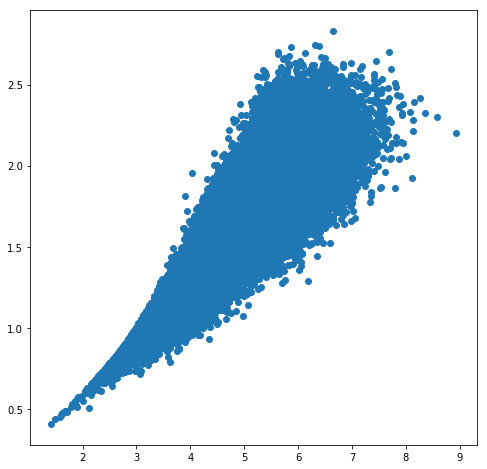

In [291]:
mpl.rcParams['figure.figsize'] = (8,8)
plt.scatter(disVec, disAngVec)

### We conclude that the metrics are correlated